In [1]:
import warnings
warnings.filterwarnings('ignore')


# Cross Validation

resnet18

no fc layer

surv_net : 

            ( 512 , 512 ) - ReLU - Batchnorm -  Dropout(0.5)

            ( 2048 , 512 ) - ReLU - Batchnorm - Dropout(0.5)

            ( 512 , 16 ) - ReLu - Batchnorm - Dropout(0.5) 
            
            ( 16 , 1 ) - 
 
'''

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.models as models

In [3]:
def seed_everything(random_state=0):
    """
    Fix randomness for deterministic results
    :param random_state: random state generating random numbers
    :return: None
    """

    np.random.seed(random_state)
    _ = torch.manual_seed(random_state)
    torch.cuda.manual_seed(random_state)
    torch.cuda.manual_seed_all(random_state)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
random_state = 0
seed_everything(random_state)

In [5]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [1]:

# df = pd.read_excel('/home/hyungyu/survival_analysis/paper_ex/new_data_0818.xlsx')
# df

In [7]:
df = df.drop(columns=['Unnamed: 0','D_date','pic_date'])

In [2]:
# df = df.sample(100)
# df

In [10]:
print((df['event']==0).sum(), (df['event']==1).sum())

748 210


## PyTorch dataset

In [14]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from PIL import Image

In [15]:
class MyDataset(Dataset):
    def __init__(self, file_list, labels, transform=None):
        super().__init__()
        self.file_list = file_list
        self.labels = labels
        self.transform = transform
        
    def __getitem__(self, ix):
        filename = self.file_list[ix]
        img = Image.open(filename).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        label = torch.from_numpy(self.labels[ix])
        return img, label
    
    def __len__(self):
        return len(self.file_list)
    
    def calculate_weights(self):
        event_samples = [0, 0] # label 0, label 1
        for label in self.labels:
            event_samples[int(label[2])] += 1 # event label
        event_weights = 1. / torch.tensor(event_samples, dtype=torch.float)
        weights = event_weights[self.labels[:,2]] # event label
        return weights
    

## Image transforms

In [16]:
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transforms = {
    'train': T.Compose([
        T.RandomResizedCrop(size, scale = (0.5, 1.0)),
        T.RandomHorizontalFlip(),
        T.ColorJitter(brightness = 0.3, contrast= 0.3),
        T.RandomAffine(degrees= 20, translate = (0.1,0.1), shear=(-10,10)),
        T.ToTensor(),
        T.Normalize(mean, std)
    ]),
    'test': T.Compose([
        T.Resize(256),
        T.CenterCrop(size),
        T.ToTensor(),
        T.Normalize(mean, std)
    ])
}

In [17]:
def get_data_from_ds(ds):
    x_test = []
    y_test = []

    for x, y in ds:
        x_test.append(x.numpy())
        if isinstance(y, tuple):
            y = torch.stack(y)
        y_test.append(y.numpy())

    x_test = np.array(x_test)
    y_test = np.array(y_test)
    
    durations_test, events_test = y_test.T

    return x_test, durations_test, events_test

# Loss function

In [18]:
class CoxPHLoss(nn.Module):
    """Loss for CoxPH model. If data is sorted by descending duration, see `cox_ph_loss_sorted`.

    We calculate the negative log of $(\frac{h_i}{\sum_{j \in R_i} h_j})^d$,
    where h = exp(log_h) are the hazards and R is the risk set, and d is event.

    We just compute a cumulative sum, and not the true Risk sets. This is a
    limitation, but simple and fast.
    """
    def forward(self, log_h, label):
        durations, events = label.T
        return cox_ph_loss(log_h, durations, events)

# Model architecture

In [19]:
import torchvision.models as models

In [20]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda:0")

In [21]:
class ConvNet_SA(nn.Module):
    def __init__(self, 
                 encoded_features=512, 
                 out_features=1):
        super().__init__()
        resnet = models.resnet18(pretrained=True)
        in_features = resnet.fc.in_features
        del resnet.fc
       
        layers_to_freeze = ['stem', 'layer1', 'layer2', 'layer3']
        for name, layer in resnet.named_children():
            if name in layers_to_freeze:
                for p in layer.parameters():
                    p.requires_grad_(False)
                
        self.feature = nn.Sequential(*list(resnet.children()))
        self.fc = torch.nn.Sequential(torch.nn.Flatten()).to(device)
        
        self.surv_net = nn.Sequential(
            nn.Linear(encoded_features, encoded_features),nn.ReLU(),nn.BatchNorm1d(encoded_features),nn.Dropout(0.5),
            nn.Linear(encoded_features, 16),nn.ReLU(),nn.BatchNorm1d(16),nn.Dropout(0.5),
            nn.Linear(16, 16), nn.ReLU(),nn.BatchNorm1d(16),nn.Dropout(0.5),
            nn.Linear(16, out_features)
        )

    def forward(self, input):
        feats = self.feature(input)
        feats = self.fc(feats)
        phi = self.surv_net(feats)
        return phi

In [22]:
net = ConvNet_SA()
net.to(device)



ConvNet_SA(
  (feature): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [23]:
# from torchsummary import summary

In [24]:
# summary(net, (3,224, 224))

## Train/Val/Test split

In [25]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
from pycox.models.loss import cox_ph_loss
import torchtuples as tt

In [26]:
n_folds = 5
skf = StratifiedKFold(n_splits = 5)

In [27]:
file_list = df['file_path'].values
label_list = df[['duration', 'event']].values

In [28]:
# label_list[:,1]

In [29]:
from torch.utils.data import WeightedRandomSampler

In [3]:
train_c_index_values = []
test_c_index_values = []
test_brier_score_values = []
test_nbll_values = []
std = []


for i, (train_idx, test_idx) in enumerate(skf.split(file_list, label_list[:,1])):
    print("="*40)
    print("="*40)
    print(f'Fold {i+1} of {n_folds}')
    
    train_idx, val_idx = train_test_split(train_idx)
    
    train_file_list, train_labels = file_list[train_idx], label_list[train_idx]
    val_file_list, val_labels = file_list[val_idx], label_list[val_idx]
    test_file_list, test_labels = file_list[test_idx], label_list[test_idx]
    print(f'( Train : {len(train_file_list)} ) Survive : {np.count_nonzero(train_labels[:,1] == 0)}명 / {np.around(np.mean(train_labels[:,1] == 0)*100 , 3)}% , Dead : {np.count_nonzero(train_labels[:,1] ==1)}명 / {np.around( np.mean(train_labels[:,1] == 1)*100, 3 )}% ')
    print(f'( Val : {len(val_file_list)} ) Survive : {np.count_nonzero(val_labels[:,1] == 0)}명 / {np.around(np.mean(val_labels[:,1] == 0)*100 , 3)}% , Dead : {np.count_nonzero(val_labels[:,1] ==1)}명 / {np.around( np.mean(val_labels[:,1] == 1)*100, 3 )}% ')
    print(f'( Test : {len(test_file_list)} ) Survive : {np.count_nonzero(test_labels[:,1] == 0)}명 / {np.around(np.mean(test_labels[:,1] == 0)*100 , 3)}% , Dead : {np.count_nonzero(test_labels[:,1] ==1)}명 / {np.around( np.mean(test_labels[:,1] == 1)*100, 3 )}% ')
    
    ####
    train_df = pd.DataFrame({'file_path': train_file_list, 'duration': train_labels[:,0], 'event': train_labels[:,1]})
    val_df = pd.DataFrame({'file_path': val_file_list, 'duration': val_labels[:,0], 'event': val_labels[:,1]})
    test_df = pd.DataFrame({'file_path': test_file_list, 'duration': test_labels[:,0], 'event': test_labels[:,1]})
    ####
    
    train_ds = MyDataset(train_file_list, train_labels, transform=transforms['train'])
    val_ds   = MyDataset(val_file_list, val_labels, transform=transforms['test'])
    test_ds  = MyDataset(test_file_list, test_labels, transform=transforms['test'])
    
    x_test,durations_test, events_test = get_data_from_ds(test_ds)
    
    x_train, *y_train = get_data_from_ds(train_ds)
    
    ### DataLoader
    
    train_dl = DataLoader(train_ds, batch_size=128, shuffle = True)
    val_dl = DataLoader(val_ds, batch_size = 256)

    
    model = CoxPH(net, tt.optim.Adam, device=device, loss=CoxPHLoss())
    
    ### 실험 시작
    
    log = model.fit_dataloader(train_dl, 
                           epochs=1000, 
                           callbacks=[tt.callbacks.EarlyStopping(patience = 10)],
                           val_dataloader=val_dl, 
                           verbose=True)
    
    log.plot(); plt.plot()
    model.training_data = (x_train, y_train)
    
    # 생존 곡선 확인
    _ = model.compute_baseline_hazards()
    
    surv = model.predict_surv_df(x_test)
    
    plt.title('Fold {} - Survival Curve'.format(i+1))
    surv.iloc[:, :5].plot(drawstyle='steps-post')
    plt.ylabel('S(t | x)')
    _ = plt.xlabel('Time')
    
    # 생존분석 평가 준비
    
    ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
    time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
    # test 평가
    test_c_index = ev.concordance_td()
    test_brier_score = ev.integrated_brier_score(time_grid)
    test_nbll = ev.integrated_nbll(time_grid)
    
    # train 평가
    surv_train = model.predict_surv_df(x_train)
    ev1 = EvalSurv(surv_train, y_train[0], y_train[1], censor_surv='km')
    train_c_index = ev1.concordance_td()
    
    train_c_index_values.append(train_c_index)
    test_c_index_values.append(test_c_index)
    test_brier_score_values.append(test_brier_score)
    test_nbll_values.append(test_nbll)
    
    # Train, Test 평가 확인
    print(f'Fold {i+1} train C-Index: {train_c_index:.4f}')
    print(f'Fold {i+1} test C-Index: {test_c_index:.4f}')
    print(f"Fold {i+1} test integrated_brier_score : {ev.integrated_brier_score(time_grid)}")
    print(f"Fold {i+1} test integrated_nbll :  {ev.integrated_nbll(time_grid)}")
    print(f"Fold {i+1} test concordance_td : {ev.concordance_td()}")
    print(f'Fold {i+1} End')
    
    savePath = f'/home/hyungyu/survival_analysis/paper_ex/deepsurv/checkpoint/resnet18/{net.__class__.__name__}_Fold{i+1}.pt'
    torch.save(net.state_dict(), savePath)

avg_train_c_index = sum(train_c_index_values) / len(train_c_index_values)  
avg_test_c_index = sum(test_c_index_values) / len(test_c_index_values)
avg_test_br_score = sum(test_brier_score_values) / len(test_brier_score_values)
avg_test_nbll = sum(test_nbll_values) / len(test_nbll_values)
std_test_c_index = np.std(test_c_index_values)
# 분산 추가해야함
print(f'Average_train_C_index : {avg_train_c_index}')
print(f'Average_test_C_index : {avg_test_c_index}')
print(f'Std_test_C_index : {std_test_c_index}')
print(f'Average_test_br_score : {avg_test_br_score}')
print(f'Average_test_nbll : {avg_test_nbll}')
    

# Kaplan

In [56]:
test = surv.T
new_names = ['var'+str(i+1) for i in range(len(test.columns))]
test.columns = new_names
test['duration'] = durations_test
test['event'] = events_test

In [57]:
a = -np.log(test.iloc[:,-3]) # 위험점수
np.median(a)
test['group'] = np.where(a < np.median(a),0,1)

In [5]:
# test.iloc[:,-3]

Text(0.5, 1.0, 'Distribution of HR')

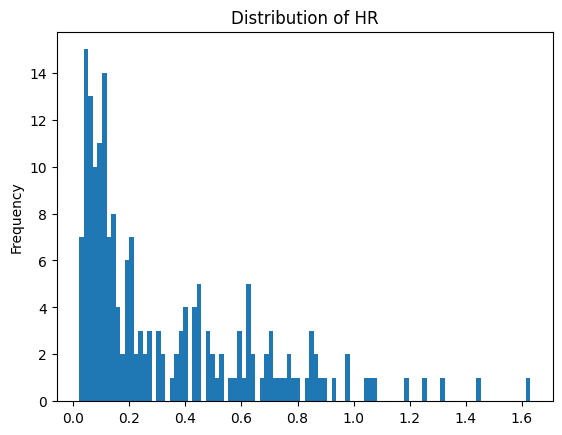

In [59]:
a.plot(kind = 'hist', bins = 100)
plt.title('Distribution of HR')

In [4]:
# surv.T

In [ ]:
surv_rate = surv.T.iloc[:,-1]
hazard_score = -1* np.log( surv_rate)
#  hazard_score # 높을 수록 사망 확률이 높다라는 의미
mean_hazard = np.median(hazard_score)

In [6]:
test2 = surv.T
bounds = np.percentile(hazard_score,[33.333, 66.666])
test2['duration'] = durations_test
test2['event'] = events_test
test2['group'] = np.where(hazard_score<bounds[0],0,np.where(hazard_score<bounds[1],1,2))
test2

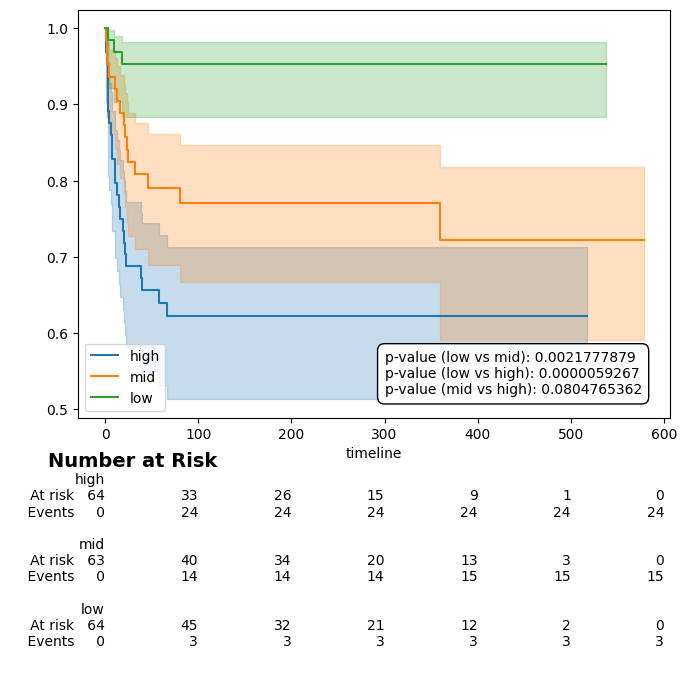

In [65]:
from lifelines.statistics import logrank_test

low_g = test2.loc[test2['group'] == 0]
middle_g = test2.loc[test2['group'] == 1]
high_g = test2.loc[test2['group'] == 2]

result12 = logrank_test(low_g['duration'], middle_g['duration'], low_g['event'], middle_g['event'])
result13 = logrank_test(low_g['duration'], high_g['duration'], low_g['event'], high_g['event'])
result23 = logrank_test(middle_g['duration'], high_g['duration'], middle_g['event'], high_g['event'])

p_value12 = format(result12.p_value,'.10f')
p_value13 = format(result13.p_value,'.10f')
p_value23 = format(result23.p_value,'.10f')

plt.figure(figsize=(7,7))
ax = plt.subplot(111)

kmf_high = KaplanMeierFitter(alpha = 0.1)
ax = kmf_high.fit(test2.loc[test2['group'] == 2]['duration'], test2.loc[test2['group'] == 2]['event'], label='high').plot_survival_function(ax=ax)

kmf_mid = KaplanMeierFitter(alpha = 0.1)
ax = kmf_mid.fit(test2.loc[test2['group'] == 1]['duration'], test2.loc[test2['group'] == 1]['event'], label='mid').plot_survival_function(ax=ax)

kmf_low = KaplanMeierFitter(alpha = 0.1)
ax = kmf_low.fit(test2.loc[test2['group'] == 0]['duration'], test2.loc[test2['group'] == 0]['event'], label='low').plot_survival_function(ax=ax)

add_at_risk_counts(kmf_high, kmf_mid, kmf_low, rows_to_show = ['At risk','Events'], ax=ax)

ax.text(-0.05, -0.12, 'Number at Risk', fontsize=14, fontweight='bold', transform=ax.transAxes)

# p-value 값을 표시하려는 위치 지정
text_position_x = 300
text_position_y = 0.52

# p-value 결과에 대한 텍스트
p_value_text = f"p-value (low vs mid): {p_value12}\np-value (low vs high): {p_value13}\np-value (mid vs high): {p_value23}"

ax.text(text_position_x, text_position_y, p_value_text, fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.tight_layout()